### The taxi drivers want to know what kind of trip yields better tips. Can you build a model for them and explain the model?

- Define metrics

The tip-related infomation is a absolute value shown in column **Tip_amount** of raw data. However, it is noticable that accurately mearsuring tips must take account of order information. Under the same scale of tips, the longer order or the order with larger amount in fare should yield more abosulte tips, compared to the shorter ones. 

Therefore, we define a new metric, **tip percentage**, to accurately measure the scale of tips:

$$ \text{tip percentage of order } i = \frac{\text{tip amount of order } i}{ \text{fare amount of order } i} $$


- Feauture Engineering 

New feature: route, the Origin-Destination (OD) pair of orders; it is an integrated feature composed by origin's loc id and the destination's loc id of orders.

we are using the following numeric features: Passenger_count, Trip_distance , duration. The categorical features (
Trip_type, Payment_type, pickup_week, pickup_hour, dropoff_hour,loc_id_Pickup, loc_id_Dropoff and route) is added to model after one-hot encoding.

- Model and performance

We are using Xgboost with 100 estimators as the prediction model, due to the vast number of features and obeservations. Due the the limit of time, techniques such as log-transformation on Y-label (commonly used on percetage values), grid search for paramter tuning and training multiple models (e.g.light-GBM model) are not applied here, but those definitely are approaches worth being tried on in future trials.

The model yields a relatively good result, with 0.0465 MAE, 0.1237 MSE and 0.3518 RMSE on predicting tip percentage. However, it is a time-demanding task and it takes around 12 hours to train this model on a 24 cores, 64G RAM server.

- Interpretation 

By outputing the top 10 important feautures and comparison analysis on those, we know that for taxi drivers want to have more tips, they may want to:

- take order starting at Coney Island

- take orders heading to Stuyvesant Heights, Bushwick South

- take orders during 2.00 am - 4.00 am or 9.00am -10.00 am



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import xgboost
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error
warnings.filterwarnings("ignore")

Data can be generated by running the part 1 notebook, or downloaded from the following links:

https://drive.google.com/file/d/1Dwd5rloa3ontg9Zwnx6HtTBRNxh3EIp6/view?usp=sharing (proceessed_data.csv)
https://drive.google.com/file/d/172cysR4PsNOqOnJ0Ml2U78-DGMQq2tmx/view?usp=sharing (region_info.csv)

In [2]:
# read in the data processed in part 1
taxi_data = pd.read_csv('proceessed_data.csv')
region_info = pd.read_csv('region_info.csv')

(array([888387.,  29477.,  54132.,  44736., 293858.,  99396.,  45407.,
         14459.,   4571.,   1080.]),
 array([0.        , 0.04973684, 0.09947368, 0.14921053, 0.19894737,
        0.24868421, 0.29842105, 0.34815789, 0.39789474, 0.44763158,
        0.49736842]),
 <a list of 10 Patch objects>)

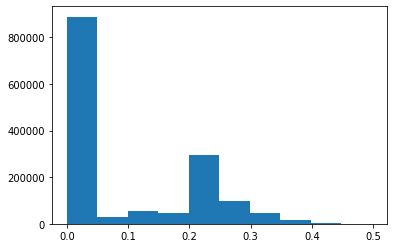

In [4]:
# define a new metric (Tip_amount/Fare_amount) to measure tips' scale 
taxi_data['tip_percentage'] = taxi_data['Tip_amount']/taxi_data['Fare_amount']

# visualize tip percentage distribution for the most orders (orders whose tip_percentage is less than 0.5)
plt.hist(taxi_data[taxi_data['tip_percentage'] < 0.5 ]['tip_percentage'],bins = 10)

In [5]:
# feaure engineering: create a new feature named as route, standing for a Origin-Destination (OD) pair 
taxi_data['route'] = taxi_data.apply(lambda x: str(x.loc_id_Pickup) + '_' + str(x.loc_id_Dropoff),axis=1)
# declare features used in the machine learning model
x_col = ['VendorID','RateCodeID','Passenger_count','Trip_distance','duration',\
         'Trip_type','Payment_type','pickup_week','pickup_hour','dropoff_hour','loc_id_Pickup','loc_id_Dropoff','route']
# specify the target column 
y_col = ['tip_percentage']

In [6]:
# extract columns used for further modeling into a new dataframe
taxi_data_for_model = taxi_data[x_col + y_col]
# convert time delta type into a numeric feature 
taxi_data_for_model['duration'] = pd.to_timedelta(taxi_data_for_model['duration']).astype('int')/1000000000

# cast time-related features into str/object type for further one-hot encoding 
taxi_data_for_model['pickup_week'] = taxi_data_for_model['pickup_week'].astype('str')
taxi_data_for_model['pickup_hour'] = taxi_data_for_model['pickup_hour'].astype('str')
taxi_data_for_model['dropoff_hour'] = taxi_data_for_model['dropoff_hour'].astype('str')

# cast order-tag-related features into str/object type for further one-hot encoding 
taxi_data_for_model.VendorID = taxi_data_for_model.VendorID.astype('str')
taxi_data_for_model.RateCodeID  = taxi_data_for_model.RateCodeID.astype('str')
taxi_data_for_model.Trip_type = taxi_data_for_model.Trip_type.astype('str')
taxi_data_for_model.Payment_type  = taxi_data_for_model.Payment_type.astype('str')

# to diminish the dimensions of one-hot encoded route feature, we convert all routes with less than
# 300 order during Sep. 2015 into value miner_route
thres_order_num = 300
route_set = taxi_data_for_model['route'].value_counts()\
        [taxi_data_for_model['route'].value_counts()> thres_order_num].index
taxi_data_for_model.route = taxi_data_for_model.route.apply(lambda x: x if x in route_set else  'minor_route')
taxi_data_for_model_dummy = pd.get_dummies(taxi_data_for_model[x_col])

In [8]:
# split training and testing set 
X_train, X_test, y_train, y_test = \
        train_test_split(taxi_data_for_model_dummy, taxi_data_for_model[y_col], test_size=0.2)

# build xgboost model to predict tip percentage 
model = xgboost.XGBRegressor(n_estimators =100, n_jobs = -1)

In [12]:
#output the predictions 
preds = model.predict(X_test)
#let predictions less than 0 equal to 0 (negative tips make no sense)
preds[preds <0] = 0

In [26]:
#model performance
print('MAE:', np.round(mean_absolute_error(y_test, preds),4))
print('MSE:', np.round(mean_squared_error(y_test, preds),4))
print('RMSE:', np.round(np.sqrt(mean_squared_error(y_test, preds)),4))

MAE: 0.0465
MSE: 0.1237
RMSE: 0.3518


In [63]:
# output the feature importance of varibles (top 10)
feature_df = pd.DataFrame()
feature_df['name'] = model._Booster.feature_names
feature_df['importance'] = model.feature_importances_
feature_df.sort_values('importance',ascending = False)[:10]

,name,importance
400,loc_id_Dropoff_193,0.122400
435,loc_id_Dropoff_225,0.073231
154,loc_id_Pickup_193,0.064472
42,pickup_hour_3,0.052478
148,loc_id_Pickup_188,0.045471
222,loc_id_Pickup_260,0.041653
48,pickup_hour_9,0.040028
489,loc_id_Dropoff_37,0.039328
37,pickup_hour_2,0.033035
255,loc_id_Pickup_55,0.022005


In [61]:
#generate advice based on top 10 the most important features (we may generate more correspondingly if not enough)
#since feature importanct in Xgboost is non-directional,
#we need to compare the tips level between target feauture = 1 or = 0

for col in feature_df.sort_values('importance',ascending = False)[:10].name:
    
    if col.split('_')[-2] == 'Dropoff' or col.split('_')[-2] == 'Pickup':
        id_ = int(col.split('_')[-1])
        print (col.split('_')[-2], ' at ', region_info[region_info.LocationID == id_].zone.values[0])
    else:
        print (col)
        
    print ('if true, orders mean tip percentage:',\
    np.round(taxi_data_for_model[taxi_data_for_model.index.isin( \
                      taxi_data_for_model_dummy[taxi_data_for_model_dummy[col] ==1].index)][y_col].values.mean(),4),\
           'else:', \
    np.round(taxi_data_for_model[taxi_data_for_model.index.isin( \
                      taxi_data_for_model_dummy[taxi_data_for_model_dummy[col] !=1].index)][y_col].values.mean(),4),\
          )
    print ()

Dropoff  at  Queensbridge/Ravenswood
if true, orders mean tip percentage: 0.0581 else: 0.0985

Dropoff  at  Stuyvesant Heights
if true, orders mean tip percentage: 0.1518 else: 0.0977

Pickup  at  Queensbridge/Ravenswood
if true, orders mean tip percentage: 0.0686 else: 0.0984

pickup_hour_3
if true, orders mean tip percentage: 0.1011 else: 0.0983

Pickup  at  Prospect-Lefferts Gardens
if true, orders mean tip percentage: 0.0972 else: 0.0984

Pickup  at  Woodside
if true, orders mean tip percentage: 0.0588 else: 0.0991

pickup_hour_9
if true, orders mean tip percentage: 0.1047 else: 0.0981

Dropoff  at  Bushwick South
if true, orders mean tip percentage: 0.1365 else: 0.0979

pickup_hour_2
if true, orders mean tip percentage: 0.1041 else: 0.0982

Pickup  at  Coney Island
if true, orders mean tip percentage: 0.1416 else: 0.0983

